Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

下面以minist数据集的分类模型的训练为例，演示这3种训练模型的风格。


### 准备数据

In [1]:
import torch 
from torch import nn 

import torchvision 
from torchvision import transforms


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="./data/minist/",train=True,download=True,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="./data/minist/",train=False,download=True,transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid =  torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)

print(len(ds_train))
print(len(ds_valid))

60000
10000


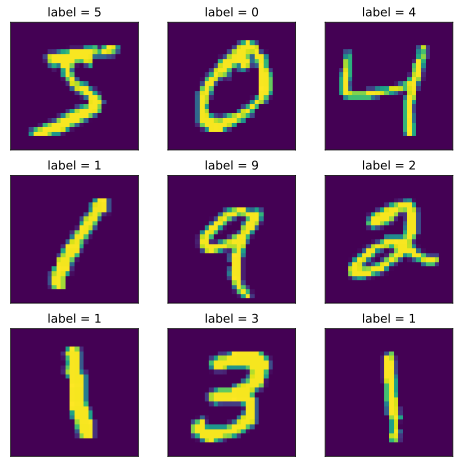

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

### 一、脚本风格

In [4]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,10))

print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


In [5]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true,y_pred_cls)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = accuracy
metric_name = "accuracy"

In [6]:
epochs = 3
log_step_freq = 100

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1):  

    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1):
    
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
            
    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training...
================================================================================2021-02-02 22:35:25
[step = 100] loss: 0.906, accuracy: 0.687
[step = 200] loss: 0.575, accuracy: 0.807
[step = 300] loss: 0.439, accuracy: 0.854
[step = 400] loss: 0.365, accuracy: 0.880

EPOCH = 1, loss = 0.332,accuracy  = 0.891, val_loss = 0.119, val_accuracy = 0.965

================================================================================2021-02-02 22:35:58
[step = 100] loss: 0.112, accuracy: 0.966
[step = 200] loss: 0.121, accuracy: 0.963
[step = 300] loss: 0.117, accuracy: 0.964
[step = 400] loss: 0.114, accuracy: 0.965

EPOCH = 2, loss = 0.112,accuracy  = 0.965, val_loss = 0.116, val_accuracy = 0.969

================================================================================2021-02-02 22:36:30
[step = 100] loss: 0.092, accuracy: 0.972
[step = 200] loss: 0.089, accuracy: 0.972
[step = 300] loss: 0.089, accuracy: 0.973
[step = 400] loss: 0.088, accuracy: 0.973

EPOCH = 3

### 二、函数风格
该风格在脚本形式上作了简单的函数封装。

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [8]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true,y_pred_cls)

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = nn.CrossEntropyLoss()
model.metric_func = accuracy
model.metric_name = "accuracy"

In [9]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

@torch.no_grad()
def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)

(2.311720609664917, 0.0859375)

In [10]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1,epochs+1):  

        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    return dfhistory

In [11]:
epochs = 3
dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 100)

Start Training...
================================================================================2021-02-02 22:37:04
[step = 100] loss: 2.304, accuracy: 0.096
[step = 200] loss: 2.291, accuracy: 0.120
[step = 300] loss: 2.278, accuracy: 0.164
[step = 400] loss: 2.262, accuracy: 0.209

EPOCH = 1, loss = 2.248,accuracy  = 0.232, val_loss = 2.134, val_accuracy = 0.474

================================================================================2021-02-02 22:37:40
[step = 100] loss: 2.101, accuracy: 0.360
[step = 200] loss: 2.047, accuracy: 0.385
[step = 300] loss: 1.986, accuracy: 0.411
[step = 400] loss: 1.922, accuracy: 0.437

EPOCH = 2, loss = 1.870,accuracy  = 0.457, val_loss = 1.435, val_accuracy = 0.732

================================================================================2021-02-02 22:38:14
[step = 100] loss: 1.409, accuracy: 0.624
[step = 200] loss: 1.311, accuracy: 0.648
[step = 300] loss: 1.210, accuracy: 0.675
[step = 400] loss: 1.119, accuracy: 0.698

EPOCH = 3

### 三、类风格 torchkeras.Model
此处使用torchkeras.Model构建模型，并调用compile方法和fit方法训练模型。

使用该形式训练模型非常简洁明了。

In [12]:
import torchkeras 

class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
model = torchkeras.Model(CnnModel())
print(model)

Model(
  (net): CnnModel(
    (layers): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): AdaptiveMaxPool2d(output_size=(1, 1))
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=64, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


In [13]:
model.summary(input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [14]:
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.numpy(),y_pred_cls.numpy())

model.compile(loss_func = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

dfhistory = model.fit(3,dl_train = dl_train, dl_val=dl_valid, log_step_freq=100) 

Start Training ...

================================================================================2021-02-02 22:38:47
{'step': 100, 'loss': 1.143, 'accuracy': 0.58}
{'step': 200, 'loss': 0.733, 'accuracy': 0.742}
{'step': 300, 'loss': 0.561, 'accuracy': 0.807}
{'step': 400, 'loss': 0.47, 'accuracy': 0.841}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.429 |  0.856   |  0.131   |    0.963     |
+-------+-------+----------+----------+--------------+

================================================================================2021-02-02 22:39:18
{'step': 100, 'loss': 0.156, 'accuracy': 0.953}
{'step': 200, 'loss': 0.169, 'accuracy': 0.951}
{'step': 300, 'loss': 0.166, 'accuracy': 0.952}
{'step': 400, 'loss': 0.173, 'accuracy': 0.951}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------

### 四、类风格 torchkeras.LightModel

In [26]:
import torchkeras 
import pytorch_lightning as pl 

class CnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    

class Model(torchkeras.LightModel):
    
    #loss,and optional metrics
    def shared_step(self,batch)->dict:
        x, y = batch
        prediction = self(x)
        loss = nn.CrossEntropyLoss()(prediction,y)
        preds = torch.argmax(nn.Softmax(dim=1)(prediction),dim=1).data
        acc = pl.metrics.functional.accuracy(preds, y)
        dic = {"loss":loss,"acc":acc} 
        return dic
    
    #optimizer,and optional lr_scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)
        return {"optimizer":optimizer,"lr_scheduler":lr_scheduler}
    
pl.seed_everything(1234)
net = CnnNet()
model = Model(net)

torchkeras.summary(model,input_shape=(1,32,32))
print(model)

AttributeError: module 'torchkeras' has no attribute 'LightModel'

In [27]:
ckpt_cb = pl.callbacks.ModelCheckpoint(monitor='val_loss')

# set gpus=0 will use cpu，
# set gpus=1 will use 1 gpu
# set gpus=2 will use 2gpus 
# set gpus = -1 will use all gpus 
# you can also set gpus = [0,1] to use the  given gpus
# you can even set tpu_cores=2 to use two tpus 

trainer = pl.Trainer(max_epochs=10,gpus = 0, callbacks=[ckpt_cb]) 

trainer.fit(model,dl_train,dl_valid)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


ModuleAttributeError: 'Model' object has no attribute 'automatic_optimization'